## Compare groups:

1. whole brain TTest between grad loadings 
* (parcel or vertex level possible)
* p-val surface map & thresholded t-stat surface map 
* --> observed: late IPS is further to DMN/motor end whereas visual closer to visual in Dyscalculics

2. Plot group average networks to vis. between network dispersion 
3. Plot ind. parcels




In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 
subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()

# plotting
fsaverage = fetch_surf_fsaverage() # default 5


In [2]:
from utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

from brainspace.utils.parcellation import map_to_labels
caNets_fsav5_mapping = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]


In [3]:
# gradient values, vertex x subject

resolution = 'vertex' # 'parcel' # 
spec = 'glasserParcel_cc-fil' if resolution == 'parcel' else 'space-fsaverag5_n10'
gms_aligned_g1 = [None] * len(subList)
gms_aligned_g2 = [None] * len(subList)

for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_{spec}.npy')) # vertex level
    gm_aligned = gm_aligned.T if resolution == 'parcel' else gm_aligned
    gms_aligned_g1[i] = gm_aligned[0,:] # 
    gms_aligned_g2[i] = gm_aligned[1,:] # 

sub_array= np.array([int(i) for i in subList]) 
n_vertices = np.shape(gms_aligned_g1)[1] # 

In [4]:
gms_g1 =  pd.DataFrame(gms_aligned_g1, index=sub_array)
gms_g1.index.name = 'subject'
gms_g1 = gms_g1.join(group_list).set_index('group',append=True)

gms_g2 =  pd.DataFrame(gms_aligned_g2, index=sub_array)
gms_g2.index.name = 'subject'
gms_g2 = gms_g2.join(group_list).set_index('group',append=True)

gms_g1['n_gradient'] = 1
gms_g2['n_gradient'] = 2

# Set 'n_gradient' as the outermost index level
gms_g1 = gms_g1.set_index('n_gradient', append=True)
gms_g2 = gms_g2.set_index('n_gradient', append=True)

# Combine the dataframes
df_gms = pd.concat([gms_g1, gms_g2]).sort_index(level='n_gradient')


In [5]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

n_grad = 2

tmp = df_gms.xs(n_grad,0,'n_gradient')
group_0 = tmp.xs(0,0,'group')
group_1 = tmp.xs(1,0,'group')

t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)
corrected_p_values = multipletests(p_values, method='fdr_bh')[1] 
print(len(p_values))

20484


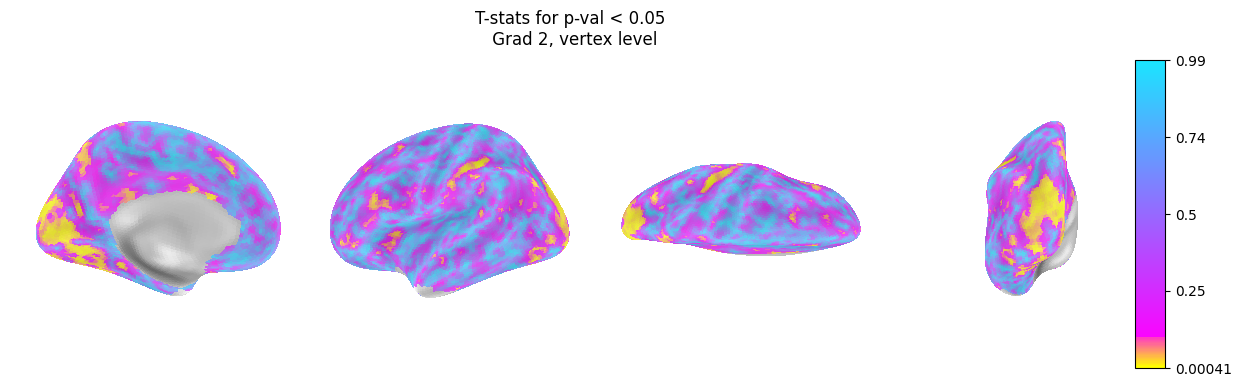

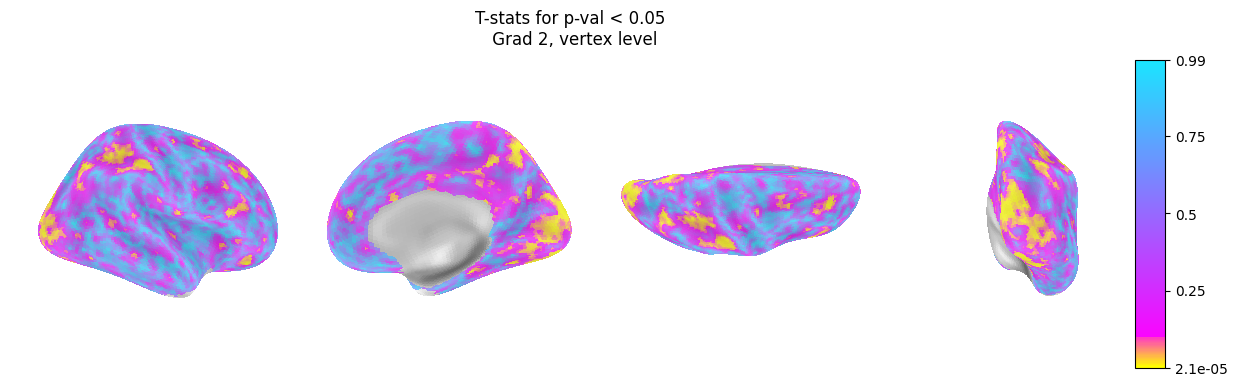

In [6]:
from brainspace.utils.parcellation import map_to_labels
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()
views = ['medial','lateral','dorsal','posterior']

if resolution == 'parcel':
    stats_fsav5 = map_to_labels(p_values, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
else:
    stats_fsav5 = p_values

for i, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, # infl_right # pial_right
                view= view,cmap=pval_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'T-stats for p-val < 0.05 \n Grad {n_grad}, {resolution} level', y=0.75)

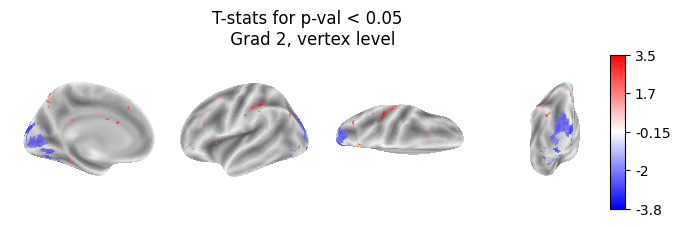

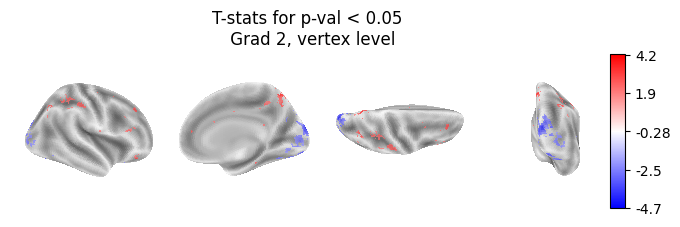

In [7]:
tstat_cmap = 'bwr'
views = ['medial','lateral','dorsal','posterior']

if resolution == 'parcel':
    stats_fsav5 = map_to_labels(t_stats, labeling_glasser, mask=mask_glasser, fill=np.nan) # parcel to vertex
else:
    stats_fsav5 = t_stats
    stats_fsav5[p_values > 0.05] = np.nan

for i, hemi in enumerate(['L','R']):
    map = np.split(stats_fsav5,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (8,4), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, # infl_right # pial_right
                view= view,cmap=tstat_cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'T-stats for p-val < 0.05 \n Grad {n_grad}, {resolution} level', y=0.8)

# observed: late IPS is further to DMN/motor end whereas visual closer to visual in Dyscalculics


In [12]:
# visualize what the diff means on gradients axis (vertex level)

group_0 = tmp.xs(0,0,'group')
group_1 = tmp.xs(1,0,'group')

t_stats, p_values = ttest_ind(group_0, group_1, axis=0, equal_var=False)

stat_mask = np.ones_like(t_stats, dtype=bool)
stat_mask[p_values > 0.05] = False

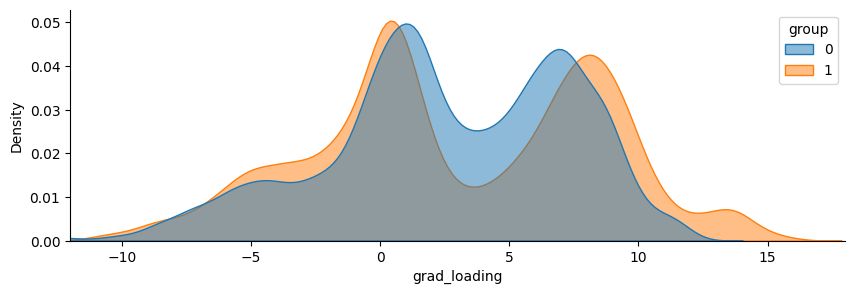

In [ ]:
tmp_tmp = tmp.loc[:, stat_mask].melt(var_name='vertex', value_name='grad_loading',ignore_index=False).dropna()
tmp_tmp = tmp_tmp.set_index('vertex', append=True).groupby(['group','vertex']).mean() # optional!

fig,axs= plt.subplots(1,1,figsize=(10,3))
sns.kdeplot(tmp_tmp.reset_index(), x='grad_loading',hue='group', fill=True,  alpha=0.5)
axs.set(xlim=(-12,18))
sns.despine()

## Plot group average networks to vis. between network dispersion 
(from dyads in 'networkDispersion-02' )

In [6]:
n_grad = 1
gms = gms_aligned_g2 if n_grad == 2 else gms_aligned_g1
df = pd.DataFrame(gms, index=sub_array, columns = [f"vertex_{i+1}" for i in range(np.shape(gms_aligned_g1)[1])])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

netAtlas_mapping = np.array(glasser_CAatlas_mapping['ca_network']) if resolution == 'parcel' else caNets_fsav5_mapping
df = pd.DataFrame(np.array([df.xs(0,0,'group').mean().values, df.xs(1,0,'group').mean().values, netAtlas_mapping]).T,
                         columns =['control','dyscalc','ca_network' ]) 


In [7]:
df.head()

,control,dyscalc,ca_network
0,21.383133,24.038435,1.0
1,19.023213,20.740984,2.0
2,16.232608,18.414533,2.0
3,21.541667,24.834286,2.0
4,23.886368,27.355407,2.0


In [ ]:
# 296 & 297 interesting

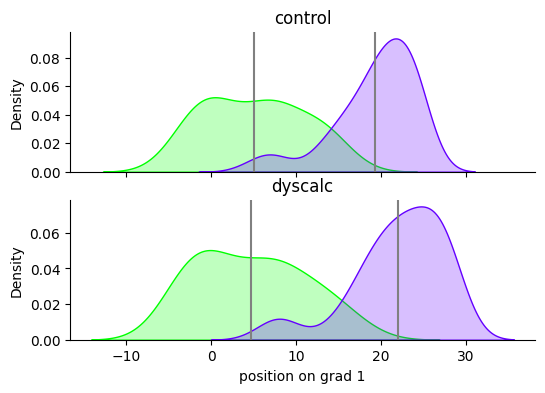

In [ ]:
import hcp_utils as hcp

rgb = np.array(list(hcp.ca_network['rgba'].values())[1:])

fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
for network_label in [5,2]:
    temp = df[df['ca_network'] == network_label]
    sns.kdeplot(temp,x='control',fill=True,color=rgb[int(network_label-1)], ax=axs[0],legend=False )
    sns.kdeplot(temp,x='dyscalc',fill=True,color=rgb[int(network_label-1)], ax=axs[1],legend=False )
    axs[0].axvline(x=temp['control'].mean(),c='grey')
    axs[1].axvline(x=temp['dyscalc'].mean(),c='grey')   

axs[0].set(title='control')#, xlim=(-6.5,9))
axs[1].set(title='dyscalc', xlabel=f'position on grad {n_grad}')#, xlim=(-6.5,9))
sns.despine()

#  vis. position of individual parcels (as only small portion of dorsal-attention network shows sign.?!)
#for parcel,c in zip([296,297],['grey','black']): # ,297
#    axs[0].axvline(x=df.loc[parcel-1]['control'],c=c)
#    axs[1].axvline(x=df.loc[parcel-1]['dyscalc'],c=c)


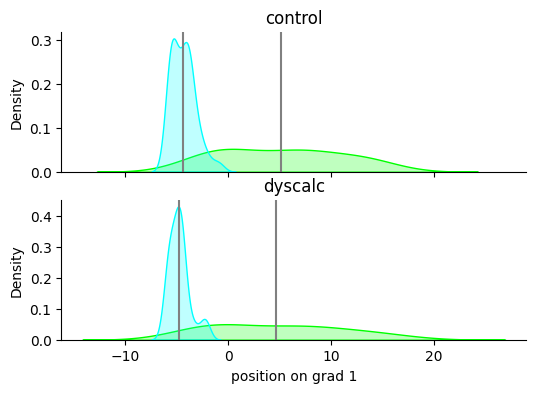

In [14]:
fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)

for network_label in [5,3]:
    temp = df[df['ca_network'] == network_label]
    sns.kdeplot(temp,x='control',fill=True,color=rgb[int(network_label-1)], ax=axs[0],legend=False )
    sns.kdeplot(temp,x='dyscalc',fill=True,color=rgb[int(network_label-1)], ax=axs[1],legend=False )
    axs[0].axvline(x=temp['control'].mean(),c='grey')
    axs[1].axvline(x=temp['dyscalc'].mean(),c='grey')   

axs[0].set(title='control')#, xlim=(-6.5,9))
axs[1].set(title='dyscalc', xlabel=f'position on grad {n_grad}')#, xlim=(-6.5,9))
sns.despine()


## Plot indiv. Parcel (of specific network) on surface

In [95]:
# plot parcel
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
network_label = 5 # dorsal-attention
cmap_two = ListedColormap(['white',rgb[network_label-1] ], 'custom_colormap')

mapping = glasser_CAatlas_mapping.reset_index().copy()
mapping['glasser_parcel'] += 1
parcels_of_interest = mapping[mapping['ca_network'] == network_label]['glasser_parcel'].values

glassers_fsav5 = map_to_labels(mapping['glasser_parcel'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]



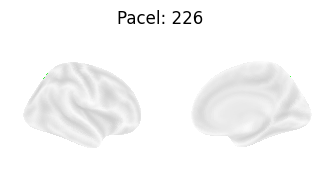

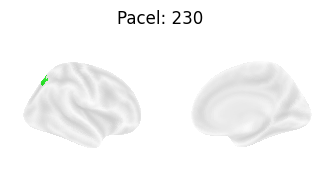

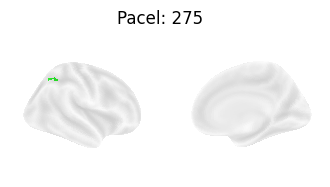

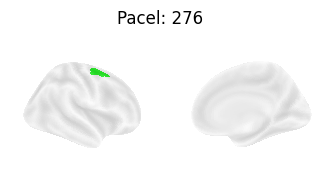

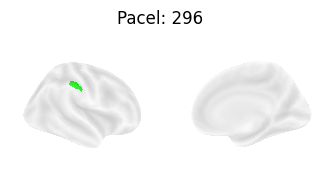

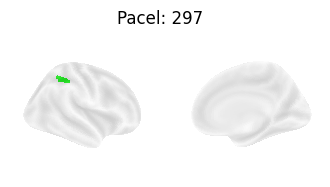

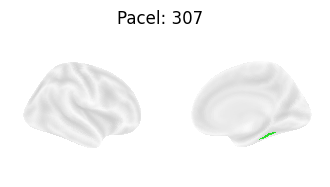

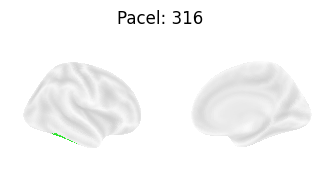

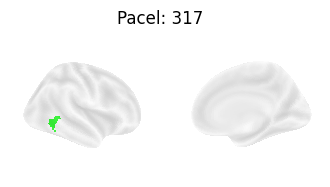

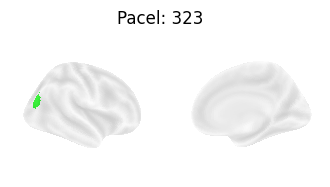

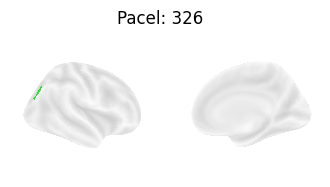

In [103]:
for parcel_n in parcels_of_interest[12:]:
    map = np.split(glassers_fsav5,2)[1].astype(float) # for i, hemi in enumerate(['L', 'R']): --> left firs

    map[map != parcel_n] = 0 #np.nan
    map[map == parcel_n] = 1
    figure, axes = plt.subplots(nrows=1, ncols=2,figsize = (4,2), subplot_kw=dict(projection='3d'))
    for i, view in enumerate(['medial','lateral']):
        nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= map, # infl_right # pial_right
                    view=view,cmap=cmap_two, colorbar=False, axes=axes[i],
                    bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) #

    figure.suptitle(f'Pacel: {parcel_n}')

### Additional

net_n = 2 # visual2 = 2 (label number)
visual2_mask = np.array(glasser_CAatlas_mapping['ca_network'] == net_n)#(glasser_CAatlas_mapping['ca_network'] == net_n).tolist()

gms_aligned_g1 = np.array(gms_aligned_g1)[:,visual2_mask]
gms_aligned_g2 = np.array(gms_aligned_g2)[:,visual2_mask]